# Import

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-08-13 15:04:40.618661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-13 15:04:41.627016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-08-13 15:04:41.627137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

Num GPUs Available: 1


2025-08-13 15:04:42.477052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-13 15:04:42.511742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-13 15:04:42.515350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# General data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Utilities
import json
import os
import random
import csv

# Deep learning (used for future autoencoder or sequence models)
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Signal processing (for resampling segments)
from scipy.signal import resample

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Cloud storage access
from google.cloud import storage

# Load and Prepare Train Data

In [3]:
# CSV containing filepaths and labeled time segments (start/end indices)
results_csv = "labeled_s2.csv"
df_csv = pd.read_csv(results_csv)

# Get all unique filepaths used in the dataset
filepaths = set([val["filepath"] for index, val in df_csv.iterrows()])

# Load each file, remove unstable regions, and keep only alpha/beta angles
X_tot = []
for file in filepaths : 
    df = pd.read_parquet(file)
    df = df.iloc[125:-7500]
    X_file = df[["alpha_angle", "beta_angle"]].to_numpy()
    X_tot.append(dict(filepath = file, data = X_file))

# Separate rows by label type for reference
black = df_csv[df_csv["label"] == "Black"]
grey = df_csv[df_csv["label"] == "Grey"]
white = df_csv[df_csv["label"] == "White"]

len(black), len(grey), len(white)

(500, 130, 500)

In [4]:
# Prepare training data
data_train, index_train, label_train = [], [], []

# Indices of all white/black segments in the dataframe
white_indices = [i for i, val in df_csv.iterrows() if val["label"] == "White"]
black_indices = [i for i, val in df_csv.iterrows() if val["label"] == "Black"]

# Randomly select 75 white and 75 black segments for training
selected_white = random.sample(white_indices, 350)
selected_black = random.sample(black_indices, 350)

# Extract time windows from the selected labeled segments
for index, val in df_csv.iterrows():
    file = val["filepath"]
    start = val["start_index"]

    if index in selected_white :
        label = 0
    elif index in selected_black :
        label = 1
    else:
        continue # Skip "exclude" or "grey" segments

    X = [X["data"] for X in X_tot if X["filepath"] == file][0]
    X = X[val["start_index"]:val["end_index"]]
    label_train.append(label)
    index_train.append(index)
    data_train.append(np.array(X))

In [5]:
# Resample and prepare LSTM input shape
window_size, sample = 1024, 8192

# Resample all data to a fixed size of 8192 samples
data_resampled = [resample(X, sample, axis=0) for X in data_train]
all_data = np.concatenate(data_resampled, axis=0)

# Then reshape to (nb_segments, window_size, 2)
X_all = all_data.astype(np.float32).reshape(-1, window_size, 2)

# Build the label array (repeat label for each segment)
Y_all = np.concatenate([np.full((len(X) // window_size, 1), label) for X, label in zip(data_resampled, label_train)])
X_all.shape, Y_all.shape

((5600, 1024, 2), (5600, 1))

# Model

In [6]:
# Define LSTM classification model
model = Sequential([
    Input(shape=(window_size, 2)),
    LSTM(128, return_sequences = True, activation = 'tanh'),
    LSTM(64, return_sequences = True, activation = 'tanh'),
    LSTM(4, activation = 'tanh'),
    Dense(1, activation = 'sigmoid')
])

# Compile the model for binary classification
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2025-08-13 15:06:36.995158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-13 15:06:36.996223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-13 15:06:37.001121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-13 15:06:37.004306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [8]:
# Train the model
history = model.fit(X_all, Y_all,
          epochs=50,
          batch_size=32,
          validation_split=0.3,
          verbose=2,
          shuffle=True)

Epoch 1/50
123/123 - 10s - loss: 0.2493 - accuracy: 0.8954 - val_loss: 0.3815 - val_accuracy: 0.8114 - 10s/epoch - 83ms/step
Epoch 2/50
123/123 - 10s - loss: 0.2183 - accuracy: 0.9130 - val_loss: 0.4054 - val_accuracy: 0.8227 - 10s/epoch - 82ms/step
Epoch 3/50
123/123 - 10s - loss: 0.2043 - accuracy: 0.9247 - val_loss: 0.3738 - val_accuracy: 0.8507 - 10s/epoch - 82ms/step
Epoch 4/50
123/123 - 10s - loss: 0.1999 - accuracy: 0.9334 - val_loss: 0.3488 - val_accuracy: 0.8435 - 10s/epoch - 82ms/step
Epoch 5/50
123/123 - 10s - loss: 0.2794 - accuracy: 0.9089 - val_loss: 0.3579 - val_accuracy: 0.8525 - 10s/epoch - 82ms/step
Epoch 6/50
123/123 - 10s - loss: 0.2095 - accuracy: 0.9280 - val_loss: 0.4083 - val_accuracy: 0.8305 - 10s/epoch - 82ms/step
Epoch 7/50
123/123 - 10s - loss: 0.2036 - accuracy: 0.9250 - val_loss: 0.3258 - val_accuracy: 0.8566 - 10s/epoch - 82ms/step
Epoch 8/50
123/123 - 10s - loss: 0.2079 - accuracy: 0.9206 - val_loss: 0.3481 - val_accuracy: 0.8233 - 10s/epoch - 83ms/step


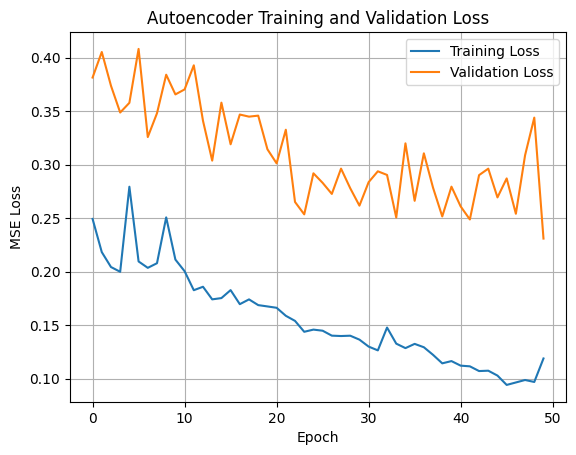

In [9]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load and Prepare Test Data

In [10]:
data_test, index_test = [], []

# Loop through remaining labeled segments (excluding training)
for index, val in df_csv.iterrows() :
    if index not in index_train and val["label"] != "Exclude" and val["label"] != "Grey" :
        file = val["filepath"]
        X = [X["data"] for X in X_tot if X["filepath"] == file][0]
        X = X[val["start_index"]:val["end_index"]]
        index_test.append(index)
        data_test.append(np.array(X))

In [11]:
# Resample and reshape the test set
data_resampled = [resample(X, sample, axis=0) for X in data_test]
all_test = np.concatenate(data_resampled, axis=0)

X_test = all_test.astype(np.float32).reshape(-1, window_size, 2)
X_test.shape

(2400, 1024, 2)

In [12]:
# Predict with trained model
prediction = model.predict(X_test)
results = []
print("min :", np.min(prediction), "  max :", np.max(prediction))

# Store results: prediction score + true label
for i in range(len(prediction)) :
    j = index_test[i//8]
    results.append(dict(index = j, pred = prediction[i], label = df_csv.iloc[j]["label"]))

75/75 [==============================] - 3s 31ms/step
min : 0.0075673074   max : 0.99832016


# Files Results

In [14]:
# Aggregate predictions per original file
gather_file = []
for ind in index_test :
    file_info = df_csv.loc[ind]
    pred_values = [round(float(x["pred"]),3) for x in results if x["index"] == ind]
    gather_file.append(dict(index = ind, values = pred_values, label = file_info["label"]))

In [15]:
# Find optimal threshold for classification
def find_lim(lim) :
    mat_2 = np.zeros((2,2))
    mat_2[0,0] = sum([1 for x in gather_file if np.mean(x["values"]) < lim and x["label"] == "White"])#/len(prediction)
    mat_2[0,1] = sum([1 for x in gather_file if np.mean(x["values"]) >= lim and x["label"] == "White"])#/len(prediction)
    mat_2[1,0] = sum([1 for x in gather_file if np.mean(x["values"]) < lim and x["label"] == "Black"])#/len(prediction)
    mat_2[1,1] = sum([1 for x in gather_file if np.mean(x["values"]) >= lim and x["label"] == "Black"])#/len(prediction)
    return (mat_2[0,0]+mat_2[1,1])/np.sum(mat_2)*100, mat_2

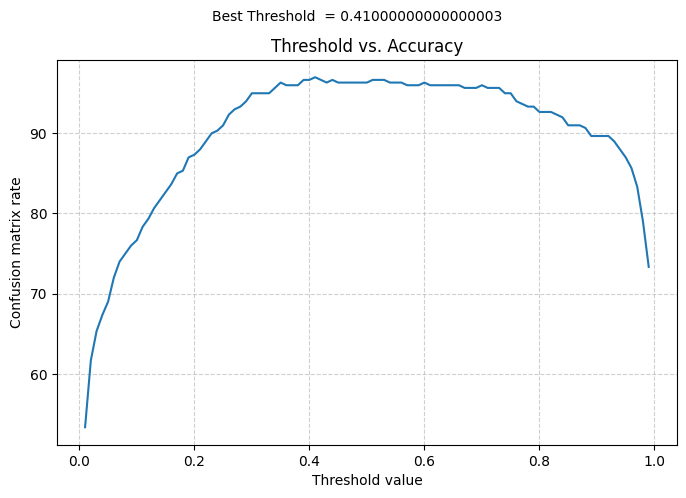

In [16]:
# Compute accuracy for various thresholds
X = np.arange(0.01, 1.0, 0.01)
Y = np.array([find_lim(x)[0] for x in X])
best_ind = np.argmax(Y)
best_thres = X[best_ind]

# Plot threshold vs accuracy
plt.figure(figsize = (8, 5))
plt.plot(X, Y)
plt.title("Threshold vs. Accuracy")
plt.suptitle("Best Threshold  = "+str(best_thres), fontsize=10)
plt.xlabel("Threshold value")
plt.ylabel("Confusion matrix rate")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

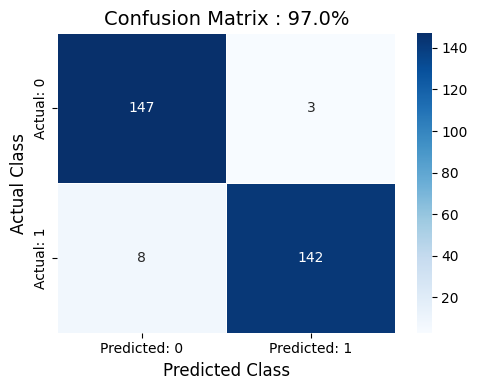

In [18]:
# Plot confusion matrix for threshold = 0.5
plt.figure(figsize=(5, 4))
sns.heatmap(find_lim(0.5)[1], annot=True, fmt=".0f", cmap="Blues", linewidths=0.5,
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])

# Titles and labels in English
plt.title("Confusion Matrix : "+str(round(Y[best_ind],2))+"%", fontsize=14)
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)

plt.tight_layout()
plt.show()

# Save model

In [ ]:
model.save("Labeled_model_new", save_format="tf")

# Visualisation

In [19]:
# Visualize false positives and false negatives
lim = 0.5
FP = [[np.mean(x["values"]), x["index"]] for x in gather_file if np.mean(x["values"]) >= lim and x["label"] == "White"]
FN = [[np.mean(x["values"]), x["index"]] for x in gather_file if np.mean(x["values"]) < lim and x["label"] == "Black"]

FP_index = [x[1] for x in FP]
FN_index = [x[1] for x in FN]
FP_index, FN_index

([401, 501, 525], [129, 605, 973, 1012, 1020, 1021, 1028, 1055])

In [34]:
df_csv = pd.read_csv("labeled_s2.csv")

df_csv.loc[500]["label"] = 'Black'

#df.to_csv("mon_fichier.csv", index=False)

/var/tmp/ipykernel_221351/29907183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv.loc[500]["label"] = 'Black'


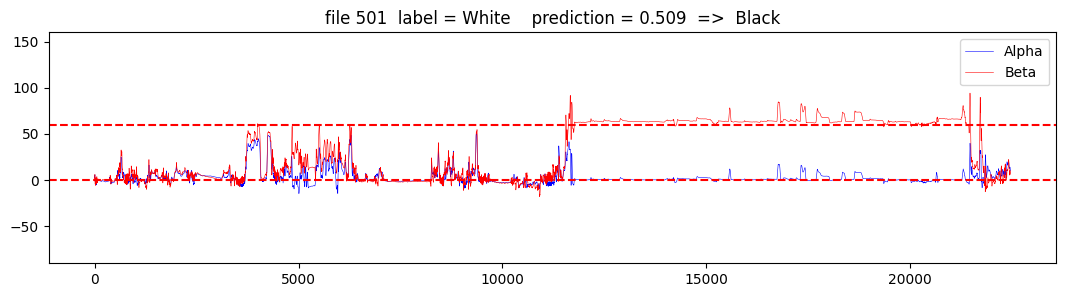

In [30]:
# White = 0 // Black = 1
i = 501 # Same index in Analyze
file_infos = df_csv.loc[i]

df = pd.read_parquet(file_infos["filepath"])
df = df.iloc[125:].iloc[:-7500]

X = df[["alpha_angle", "beta_angle"]].to_numpy()
X = X[file_infos["start_index"]:file_infos["end_index"]]

pred_v = np.mean([v["values"] for v in gather_file if v["index"] == i])
label_v = [v["label"] for v in gather_file if v["index"] == i]
pred_label = "Black" if pred_v > lim else "White"

plt.figure(figsize=(13, 3))
plt.plot(X[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(X[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axhline(y=60.0, color='r', linestyle='--')
plt.title("file "+str(i)+"  label = "+label_v[0]+"    prediction = "+str(round(pred_v,3))+"  =>  "+pred_label)
plt.ylim(-90, 160)
plt.legend()
plt.show()